# <center> Recommender System </center>

## Preparation

Connect to drive (if needed)

In [90]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

DRIVE_DIR = ""
USING_DRIVE = False
if USING_DRIVE:
    # from google.colab import drive
    # drive.mount('/content/drive')
    DRIVE_DIR = "drive/My Drive/Bangkit/"

# Check GPU
devices = tf.config.experimental.list_physical_devices()
for device in devices:
    print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Constants

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

LOG_NAME = "recommender-aggcateg-SMOTE"
REMARK = "Try current best model with aggregated category data"
BATCH_SIZE = 1024
LEARNING_RATE = 1e-5
EPOCH = 100
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FN = tf.keras.losses.MeanSquaredError()

Log dir

In [92]:
DETAIL_DIR = os.path.join(DRIVE_DIR, "log/detail/")
MODEL_DIR = os.path.join(DRIVE_DIR, "log/model/savedmodel/")
KERAS_DIR = os.path.join(DRIVE_DIR, "log/model/keras/")
PLOT_DIR = os.path.join(DRIVE_DIR, "log/plot")
SUMMARY_DIR = os.path.join(DRIVE_DIR, "log/model/summary/")

if (os.path.exists(os.path.join(MODEL_DIR, LOG_NAME)) or 
    os.path.exists(os.path.join(KERAS_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(PLOT_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(SUMMARY_DIR, LOG_NAME)) or
    os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME))):
    raise FileExistsError


## Data Extraction

### Load data from CSV

Not using user data for a while

Data is generated randomly using Excel

In [93]:
DATA_DIR = os.path.join(DRIVE_DIR, "data/synt_data_better_price_and_follower/")
INFLUENCER_FILE = os.path.join(DATA_DIR, "data_content_influencer_categ.csv")
OWNER_FILE = os.path.join(DATA_DIR, "data_content_owner_categ.csv")
HISTORY_FILE = os.path.join(DATA_DIR, "historical_data.csv")

df_influencer = pd.read_csv(INFLUENCER_FILE)
# df_owner = pd.read_csv(OWNER_FILE)
df_history = pd.read_csv(HISTORY_FILE)

### Data Exploration

In [94]:
df_influencer.head(5)

,id,insta_follower,tiktok,youtube,categories,price_category,avg_rating
0,1723,HIGH,HIGH,HIGH,"Category 8,Category 2",LOW,9.37
1,82,HIGH,HIGH,HIGH,"Category 4,Category 2,Category 1,Category 8,Ca...",MEDIUM,9.26
2,296,HIGH,HIGH,HIGH,"Category 6,Category 1,Category 4,Category 5",HIGH,9.25
3,127,HIGH,HIGH,HIGH,"Category 7,Category 6",MEDIUM,9.17
4,137,HIGH,HIGH,HIGH,"Category 6,Category 1,Category 4,Category 5",HIGH,9.16


In [95]:
df_influencer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6406 entries, 0 to 6405
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              6406 non-null   int64  
 1   insta_follower  6406 non-null   object 
 2   tiktok          6406 non-null   object 
 3   youtube         6406 non-null   object 
 4   categories      6406 non-null   object 
 5   price_category  6406 non-null   object 
 6   avg_rating      6406 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 350.5+ KB


In [96]:
df_influencer.describe()

,id,avg_rating
count,6406.000000,6406.000000
mean,3505.326881,6.954530
std,2153.761090,0.804705
min,1.000000,2.000000
25%,1607.250000,6.500000
50%,3312.500000,7.010000
75%,5384.750000,7.470000
max,7387.000000,9.370000


In [97]:
df_history.head(5)

,own_id,inf_id,star_rating,sentiment_rating
0,1,1,4,0.77
1,1,3,3,0.53
2,1,5,5,0.89
3,1,6,5,0.90
4,1,7,4,0.80


In [98]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413446 entries, 0 to 413445
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   own_id            413446 non-null  int64  
 1   inf_id            413446 non-null  int64  
 2   star_rating       413446 non-null  int64  
 3   sentiment_rating  413446 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 12.6 MB


In [99]:
df_history.describe()

,own_id,inf_id,star_rating,sentiment_rating
count,413446.000000,413446.000000,413446.000000,413446.000000
mean,2443.219533,1076.748458,4.141170,0.777486
std,1438.596784,1148.850785,0.789503,0.161847
min,1.000000,1.000000,1.000000,0.000000
25%,1214.000000,260.000000,4.000000,0.680000
50%,2456.000000,639.000000,4.000000,0.790000
75%,3699.000000,1532.000000,5.000000,0.900000
max,5000.000000,7385.000000,5.000000,1.000000


## Data Transformation

### Data cleaning

#### Missing value

In [100]:
df_influencer.isnull().sum()

id                0
insta_follower    0
tiktok            0
youtube           0
categories        0
price_category    0
avg_rating        0
dtype: int64

In [101]:
df_history.isnull().sum()

own_id              0
inf_id              0
star_rating         0
sentiment_rating    0
dtype: int64

No missing value

#### Irrelevant Data / Invalid Data

Check if all history has valid influencer and owner ID

In [102]:
df_history["inf_id"].isin(df_influencer["id"]).all()

True

All history data has valid influencer and owner ID

### Data Normalization

Normalize influencer data: Scale follower count and One-hot categories

In [103]:
def one_hot(df, column):
    one_hot = df[column].str.get_dummies()
    col_name = one_hot.columns
    new_name = list(map(lambda name: column + "_" + name, col_name))
    one_hot.rename(columns={k: v for k, v in zip(col_name, new_name)}, inplace=True)

    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(column, axis=1)
    return df


In [104]:
# follower_scaler = MinMaxScaler()
rating_scaler = MinMaxScaler()

df_inf_norm = df_influencer.copy()
df_inf_norm['avg_rating'] = rating_scaler.fit_transform(df_inf_norm[['avg_rating']])
# df_inf_norm[["insta_follower", "tiktok", "youtube"]] = follower_scaler.fit_transform(df_inf_norm[["insta_follower", "tiktok", "youtube"]])

df_inf_norm = one_hot(df_inf_norm, 'price_category') 

one_hot_categories = df_inf_norm['categories'].str.get_dummies(sep=',')
df_inf_norm = pd.concat([df_inf_norm, one_hot_categories], axis=1)
df_inf_norm = df_inf_norm.drop('categories', axis=1)

df_inf_norm = one_hot(df_inf_norm, 'youtube') 
df_inf_norm = one_hot(df_inf_norm, 'tiktok') 
df_inf_norm = one_hot(df_inf_norm, 'insta_follower') 

df_inf_norm.head()

,id,avg_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Category 1,Category 10,Category 2,Category 3,Category 4,...,Category 9,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1723,1.000000,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1,82,0.985075,0,0,1,1,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
2,296,0.983718,1,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
3,127,0.972863,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,137,0.971506,1,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0


Combine star and sentiment rating

In [105]:
STAR_WEIGHT = 0.6
SENTIMENT_WEIGHT = 0.4

df_history["combined_rating"] = STAR_WEIGHT * df_history["star_rating"] / 5 + SENTIMENT_WEIGHT * df_history["sentiment_rating"]
df_history

,own_id,inf_id,star_rating,sentiment_rating,combined_rating
0,1,1,4,0.77,0.788
1,1,3,3,0.53,0.572
2,1,5,5,0.89,0.956
3,1,6,5,0.90,0.960
4,1,7,4,0.80,0.800
...,...,...,...,...,...
413441,4999,49,5,0.90,0.960
413442,4999,670,5,0.84,0.936
413443,4999,62,5,0.92,0.968
413444,4999,770,5,0.93,0.972


In [106]:
rating_count = df_history.groupby("star_rating").count()
rating_count

,own_id,inf_id,sentiment_rating,combined_rating
star_rating,,,,
1,2768,2768,2768,2768
2,9217,9217,9217,9217
3,59531,59531,59531,59531
4,197295,197295,197295,197295
5,144635,144635,144635,144635


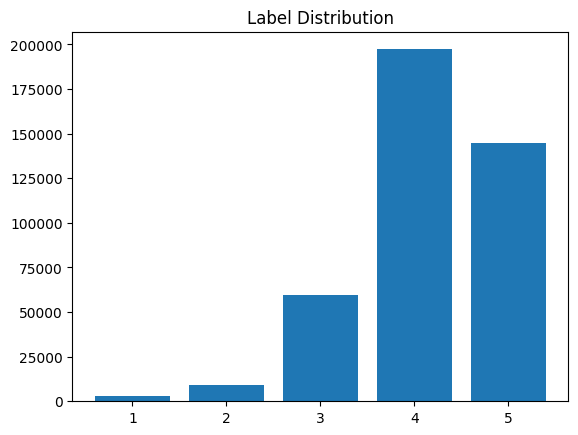

In [107]:
# Chart labels
rating_count = rating_count["own_id"].to_numpy()
ratings = range(1, 6)

# Show pie chart
plt.title("Label Distribution")
plt.bar(x=ratings, height=rating_count)
plt.show()

### Data Splitting

##### Creating user profile

In [115]:
# df_history = df_history.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features = pd.merge(df_history, df_inf_norm, left_on='inf_id', right_on='id', how='left')
df_inf_features = df_inf_features.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features.head()

,own_id,inf_id,combined_rating,id,avg_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Category 1,Category 10,...,Category 9,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1,1,0.788,1,0.725916,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0
1,1,3,0.572,3,0.658073,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,5,0.956,5,0.751696,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,1,6,0.960,6,0.910448,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,1,7,0.800,7,0.854817,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


In [116]:
OWNER_FEATURES = df_inf_norm.columns[1:]

# Copy influencer features combined with history data
df_own_norm = df_inf_features.copy()

# Multiply influencer feature with user rating
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].mul(df_own_norm['combined_rating'], axis=0) 

# Drop unimportant features
df_own_norm = df_own_norm.drop(["inf_id", "id", "combined_rating"], axis=1)

# Average those with same owner id to make user profile
df_own_norm = df_own_norm.groupby('own_id').mean().reset_index()
df_own_norm.rename(columns={'own_id': 'id'}, inplace=True)

df_own_norm = df_own_norm.drop(['avg_rating'], axis=1)
df_own_norm.head()

,id,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Category 1,Category 10,Category 2,Category 3,Category 4,Category 5,...,Category 9,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1,0.509000,0.098500,0.219500,0.297500,0.000000,0.635500,0.000000,0.000000,0.707000,...,0.000000,0.827000,0.0,0.000000,0.827000,0.0,0.000000,0.827000,0.0,0.000000
1,2,0.323497,0.220659,0.333988,0.425341,0.001749,0.502635,0.114850,0.443916,0.510335,...,0.017940,0.806192,0.0,0.071952,0.802000,0.0,0.076144,0.578563,0.0,0.299581
2,3,0.241294,0.227176,0.415882,0.381294,0.000000,0.477765,0.000000,0.352824,0.540000,...,0.000000,0.855529,0.0,0.028824,0.884353,0.0,0.000000,0.613059,0.0,0.271294
3,4,0.227707,0.247610,0.356000,0.688878,0.019220,0.414829,0.038244,0.569073,0.433073,...,0.000000,0.831317,0.0,0.000000,0.831317,0.0,0.000000,0.812780,0.0,0.018537
4,5,0.295775,0.207955,0.313483,0.290876,0.006876,0.503461,0.169303,0.276764,0.495820,...,0.051371,0.808674,0.0,0.008539,0.799730,0.0,0.017483,0.732315,0.0,0.084899


##### Process feature and label

Influencer features

In [117]:
# Remove ID and labels
df_inf_features = df_inf_features.drop(["own_id", "inf_id", "id"], axis=1)

df_inf_features.head()

,combined_rating,avg_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Category 1,Category 10,Category 2,Category 3,Category 4,...,Category 9,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,0.788,0.725916,0,1,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1,0.572,0.658073,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,0.956,0.751696,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,0.960,0.910448,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0.800,0.854817,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


In [119]:
INFLUENCER_FEATURE_COUNT = len(df_inf_features.drop("combined_rating", axis=1).columns)

Owner features

In [120]:
# Join history and owner data by own_id
df_own_features = pd.merge(df_history.drop(["star_rating", "sentiment_rating"], axis=1), df_own_norm, left_on='own_id', right_on='id', how='left')

df_own_features.head()

,own_id,inf_id,combined_rating,id,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Category 1,Category 10,Category 2,...,Category 9,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,1,1,0.788,1,0.509,0.0985,0.2195,0.2975,0.0,0.6355,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
1,1,3,0.572,1,0.509,0.0985,0.2195,0.2975,0.0,0.6355,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
2,1,5,0.956,1,0.509,0.0985,0.2195,0.2975,0.0,0.6355,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
3,1,6,0.960,1,0.509,0.0985,0.2195,0.2975,0.0,0.6355,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
4,1,7,0.800,1,0.509,0.0985,0.2195,0.2975,0.0,0.6355,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0


In [121]:
# Remove ID and labels
df_own_features = df_own_features.drop(["own_id", "inf_id", "id"], axis=1)

df_own_features.head()

,combined_rating,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Category 1,Category 10,Category 2,Category 3,Category 4,Category 5,...,Category 9,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,0.788,0.509,0.0985,0.2195,0.2975,0.0,0.6355,0.0,0.0,0.707,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
1,0.572,0.509,0.0985,0.2195,0.2975,0.0,0.6355,0.0,0.0,0.707,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
2,0.956,0.509,0.0985,0.2195,0.2975,0.0,0.6355,0.0,0.0,0.707,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
3,0.960,0.509,0.0985,0.2195,0.2975,0.0,0.6355,0.0,0.0,0.707,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
4,0.800,0.509,0.0985,0.2195,0.2975,0.0,0.6355,0.0,0.0,0.707,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0


In [123]:
OWNER_FEATURE_COUNT = len(df_own_features.drop("combined_rating", axis=1).columns)

Labels

In [124]:
# Get labels from history data
df_labels = df_history["combined_rating"]
df_labels.head()

0    0.788
1    0.572
2    0.956
3    0.960
4    0.800
Name: combined_rating, dtype: float64

##### Oversampling

In [126]:
df_inf_features = df_inf_features.drop(["combined_rating"], axis=1)
df_own_features = df_own_features.drop(["combined_rating"], axis=1)
df_own_features

,price_category_HIGH,price_category_LOW,price_category_MEDIUM,Category 1,Category 10,Category 2,Category 3,Category 4,Category 5,Category 6,...,Category 9,youtube_HIGH,youtube_LOW,youtube_MEDIUM,tiktok_HIGH,tiktok_LOW,tiktok_MEDIUM,insta_follower_HIGH,insta_follower_LOW,insta_follower_MEDIUM
0,0.509,0.0985,0.2195,0.2975,0.0,0.6355,0.0,0.000,0.707,0.000,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
1,0.509,0.0985,0.2195,0.2975,0.0,0.6355,0.0,0.000,0.707,0.000,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
2,0.509,0.0985,0.2195,0.2975,0.0,0.6355,0.0,0.000,0.707,0.000,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
3,0.509,0.0985,0.2195,0.2975,0.0,0.6355,0.0,0.000,0.707,0.000,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
4,0.509,0.0985,0.2195,0.2975,0.0,0.6355,0.0,0.000,0.707,0.000,...,0.0,0.827,0.0,0.0,0.827,0.0,0.0,0.827,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413441,0.000,0.7160,0.2430,0.9590,0.0,0.4820,0.0,0.959,0.000,0.959,...,0.0,0.959,0.0,0.0,0.959,0.0,0.0,0.959,0.0,0.0
413442,0.000,0.7160,0.2430,0.9590,0.0,0.4820,0.0,0.959,0.000,0.959,...,0.0,0.959,0.0,0.0,0.959,0.0,0.0,0.959,0.0,0.0
413443,0.000,0.7160,0.2430,0.9590,0.0,0.4820,0.0,0.959,0.000,0.959,...,0.0,0.959,0.0,0.0,0.959,0.0,0.0,0.959,0.0,0.0
413444,0.000,0.7160,0.2430,0.9590,0.0,0.4820,0.0,0.959,0.000,0.959,...,0.0,0.959,0.0,0.0,0.959,0.0,0.0,0.959,0.0,0.0


In [127]:
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import random

# Apply oversampling to each input type separately
smote = SMOTE()
df_inf_features, star_ratings = smote.fit_resample(df_inf_features, df_history['star_rating'].values)
df_own_features, _ = smote.fit_resample(df_own_features, df_history['star_rating'].values)

star_ratings = star_ratings / 5
sentiment_ratings = star_ratings - 0.1 + 0.2 * random.random()
df_labels = pd.Series(0.5 * star_ratings + 0.5 * sentiment_ratings)


##### Generate train, validation, and test dataset

In [128]:
SHUFFLE_BUFFER = 1000

dataset = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features, "own_feature": df_own_features}, df_labels))
dataset = dataset.shuffle(SHUFFLE_BUFFER) 

dataset.element_spec

({'inf_feature': TensorSpec(shape=(23,), dtype=tf.float64, name=None),
  'own_feature': TensorSpec(shape=(22,), dtype=tf.float64, name=None)},
 TensorSpec(shape=(), dtype=tf.float64, name=None))

In [129]:
# Generate training, validation, and testing data
DATASET_SIZE = dataset.cardinality().numpy()
TRAIN_SIZE = int(DATASET_SIZE * 0.95)
VAL_SIZE = int(DATASET_SIZE * 0.025)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE - VAL_SIZE

train_dataset = dataset.take(TRAIN_SIZE)
val_dataset = dataset.skip(TRAIN_SIZE).take(VAL_SIZE)
test_dataset = dataset.skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

Training dataset has 887827 data
Validation dataset has 49323 data
Testing dataset has 49325 data


In [130]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Creating Model

Model consists of two neural networks that would be combined with Dot layer. The first neural network has influencer features as input and a vector as an output. The second one has owner features as input and a vector as an output. These two vectors will be combined with Dot layer and produces a single combined rating

In [131]:
VECTOR_SIZE = 64
# tf.random.set_seed(1)

model_influencer = tf.keras.models.Sequential([
    # tf.keras.layers.Dense(units=512, activation='relu'),
    # tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=VECTOR_SIZE, activation='linear'),
])

# create the influencer input and point to the base network
input_influencer = tf.keras.layers.Input(shape=(INFLUENCER_FEATURE_COUNT), name="inf_feature")
vi = model_influencer(input_influencer)
vi = tf.linalg.l2_normalize(vi, axis=1)

model_owner = tf.keras.models.Sequential([
    # tf.keras.layers.Dense(units=512, activation='relu'),
    # tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.9),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=VECTOR_SIZE, activation='linear'),
])

# create the owner input and point to the base network
input_owner = tf.keras.layers.Input(shape=(OWNER_FEATURE_COUNT), name="own_feature")
vo = model_owner(input_owner)
vo = tf.linalg.l2_normalize(vo, axis=1)

# compute the dot product of the two vectors vi and vo
output = tf.keras.layers.Dot(axes=1)([vi, vo])

# specify the inputs and output of the model
model = tf.keras.Model([input_influencer, input_owner], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inf_feature (InputLayer)       [(None, 23)]         0           []                               
                                                                                                  
 own_feature (InputLayer)       [(None, 22)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64)           90368       ['inf_feature[0][0]']            
                                                                                                  
 sequential_1 (Sequential)      (None, 64)           184256      ['own_feature[0][0]']            
                                                                                              

In [134]:
import time

start_time = time.time()
model.compile(optimizer= OPTIMIZER, 
              loss=LOSS_FN,
              metrics=["mse", "mae"])

# model = tf.keras.models.load_model(os.path.join(KERAS_DIR, "recommender-aggcateg-currentbest"))
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCH)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/100
3470/3470 [==============================] - 38s 9ms/step - loss: 0.1297 - mse: 0.1297 - mae: 0.2884 - val_loss: 0.0129 - val_mse: 0.0129 - val_mae: 0.0518
Epoch 2/100
3470/3470 [==============================] - 29s 8ms/step - loss: 0.0731 - mse: 0.0731 - mae: 0.2181 - val_loss: 0.0340 - val_mse: 0.0340 - val_mae: 0.1547
Epoch 3/100
3470/3470 [==============================] - 29s 8ms/step - loss: 0.0678 - mse: 0.0678 - mae: 0.2067 - val_loss: 0.0481 - val_mse: 0.0481 - val_mae: 0.1956
Epoch 4/100
3470/3470 [==============================] - 28s 8ms/step - loss: 0.0637 - mse: 0.0637 - mae: 0.1987 - val_loss: 0.0589 - val_mse: 0.0589 - val_mae: 0.2219
Epoch 5/100
3470/3470 [==============================] - 30s 9ms/step - loss: 0.0576 - mse: 0.0576 - mae: 0.1869 - val_loss: 0.0800 - val_mse: 0.0800 - val_mae: 0.2649
Epoch 6/100
3470/3470 [==============================] - 29s 8ms/step - loss: 0.0508 - mse: 0.0508 - mae: 0.1730 - val_loss: 0.0819 - val_mse: 0.0819 - val_mae:

In [135]:
def plot_history(history, save=False):
    # Extract the loss, MAE, and MSE values from the history object
    loss = history.history['loss']
    mse = history.history['mse']
    mae = history.history['mae']
    val_loss = history.history['val_loss']
    val_mse = history.history['val_mse']
    val_mae = history.history['val_mae']

    # Create a figure and set up the subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

    # Plot the loss history
    plt.title(REMARK)
    ax1.plot(loss, label='Loss')
    ax1.plot(val_loss, label='Val Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the MSE history
    ax2.plot(mse, label='MSE')
    ax2.plot(val_mse, label='Val MSE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MSE')
    ax2.legend()

    # Plot the MAE history
    ax3.plot(mae, label='MAE')
    ax3.plot(val_mae, label='Val MAE')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MAE')
    ax3.legend()

    # Show the plot
    plt.tight_layout()
    if (save):
        if (not os.path.exists(os.path.join(PLOT_DIR, LOG_NAME))):
            plt.savefig(os.path.join(PLOT_DIR, LOG_NAME))
    
    plt.show()

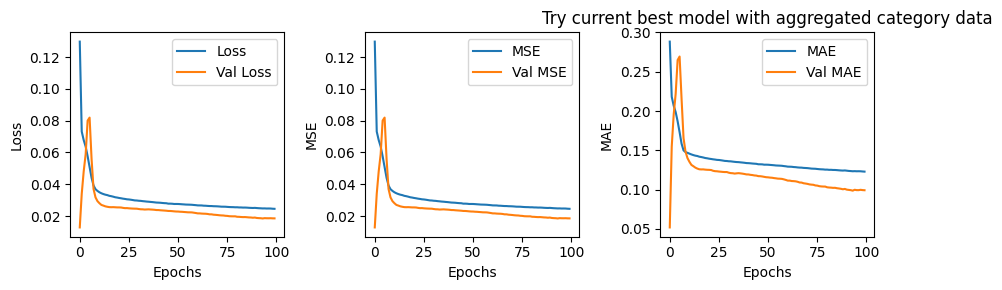

In [136]:
plot_history(history, save=True)


### Evaluation with test dataset

In [137]:
test_predict = model.predict(test_dataset)
test_predict

97/97 [==============================] - 3s 3ms/step


array([[0.5175872 ],
       [0.503312  ],
       [0.498781  ],
       ...,
       [0.5042398 ],
       [0.58145654],
       [0.51545817]], dtype=float32)

In [163]:
# Get real label
test_labels = np.array([])
test_inputs = np.array([])
for batch in test_dataset:
    test_inputs = np.concatenate([test_inputs, [batch[0]]])
    test_labels = np.concatenate([test_labels, batch[1].numpy()])

test_inputs

array([{'inf_feature': <tf.Tensor: shape=(512, 23), dtype=float64, numpy=
       array([[0.78833107, 0.        , 1.        , ..., 0.        , 0.        ,
               1.        ],
              [0.86431479, 0.        , 0.        , ..., 1.        , 0.        ,
               0.        ],
              [0.94029851, 1.        , 0.        , ..., 1.        , 0.        ,
               0.        ],
              ...,
              [0.75169607, 1.        , 0.        , ..., 0.        , 0.        ,
               1.        ],
              [0.80325645, 0.        , 1.        , ..., 1.        , 0.        ,
               0.        ],
              [0.77204885, 0.        , 1.        , ..., 1.        , 0.        ,
               0.        ]])>, 'own_feature': <tf.Tensor: shape=(512, 22), dtype=float64, numpy=
       array([[0.25552   , 0.24848   , 0.32688   , ..., 0.57344   , 0.09904   ,
               0.1584    ],
              [0.25754217, 0.27118072, 0.31036145, ..., 0.75628916, 0.        ,
  

In [139]:
compare_test = pd.concat([pd.DataFrame(test_predict, columns=["predicted"]), 
                     pd.DataFrame(test_labels, columns=["real"])], axis=1)

compare_test["error"] = abs(compare_test["predicted"] - compare_test["real"])

compare_test

,predicted,real,error
0,0.517587,0.968313,0.450726
1,0.503312,0.968313,0.465001
2,0.498781,0.568313,0.069532
3,0.674811,0.968313,0.293502
4,0.528305,0.968313,0.440008
...,...,...,...
49320,0.519411,0.968313,0.448902
49321,0.538324,0.968313,0.429989
49322,0.504240,0.968313,0.464073
49323,0.581457,0.968313,0.386856


In [145]:
compare_test[compare_test["error"] > 1e-1]

,predicted,real,error
0,0.517587,0.968313,0.450726
1,0.503312,0.968313,0.465001
3,0.674811,0.968313,0.293502
4,0.528305,0.968313,0.440008
5,0.632572,0.968313,0.335740
...,...,...,...
49320,0.519411,0.968313,0.448902
49321,0.538324,0.968313,0.429989
49322,0.504240,0.968313,0.464073
49323,0.581457,0.968313,0.386856


In [146]:
compare_test["error"].mean()

0.4217960674978026

In [147]:
train_predict = model.predict(train_dataset)
train_predict

3470/3470 [==============================] - 12s 4ms/step


array([[0.50745314],
       [0.5334255 ],
       [0.50431347],
       ...,
       [0.4817446 ],
       [0.50821275],
       [0.47054836]], dtype=float32)

In [148]:
# Get real label
train_labels = np.array([])
for batch in train_dataset:
    train_labels = np.concatenate([train_labels, batch[1].numpy()])

train_labels

array([0.76831287, 0.76831287, 0.76831287, ..., 0.56831287, 0.56831287,
       0.56831287])

In [149]:
compare_train = pd.concat([pd.DataFrame(train_predict, columns=["predicted"]), 
                     pd.DataFrame(train_labels, columns=["real"])], axis=1)

compare_train["error"] = abs(compare_train["predicted"] - compare_train["real"])

compare_train

,predicted,real,error
0,0.507453,0.768313,0.260860
1,0.533426,0.768313,0.234887
2,0.504313,0.768313,0.263999
3,0.592947,0.968313,0.375366
4,0.529613,0.968313,0.438699
...,...,...,...
1775649,0.524995,0.568313,0.043318
1775650,0.516636,0.568313,0.051677
1775651,0.481745,0.568313,0.086568
1775652,0.508213,0.568313,0.060100


In [161]:
compare_train[compare_train["error"] >= 1e-1]

,predicted,real,error
0,0.507453,0.768313,0.260860
1,0.533426,0.768313,0.234887
2,0.504313,0.768313,0.263999
3,0.592947,0.968313,0.375366
4,0.529613,0.968313,0.438699
...,...,...,...
1775617,0.438606,0.568313,0.129707
1775619,0.463377,0.568313,0.104936
1775632,0.455548,0.568313,0.112765
1775636,0.442932,0.568313,0.125381


## Logging

In [151]:
if (not os.path.exists(os.path.join(MODEL_DIR, LOG_NAME))):
    tf.saved_model.save(model, os.path.join(MODEL_DIR, LOG_NAME))

In [152]:
if (not os.path.exists(os.path.join(KERAS_DIR, LOG_NAME))):
    model.save(os.path.join(KERAS_DIR, LOG_NAME))

In [153]:
def serialize(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        raise TypeError("Object of type {} is not JSON serializable".format(type(obj)))

In [155]:
import json
from datetime import timedelta

log = {
    "name": LOG_NAME,
    "training_time": str(timedelta(training_time)),
    "remark": REMARK,
    "test_error": compare_test["error"].mean(),
    "results": {
        "last_loss": history.history["loss"][-1],
        "last_mae": history.history["mae"][-1],
        "last_mse": history.history["mse"][-1],
        "last_val_loss": history.history["val_loss"][-1],
        "last_val_mae": history.history["val_mae"][-1],
        "last_val_mse": history.history["val_mse"][-1],
    },
    "hyperparameter": {
        "learning_rate": LEARNING_RATE,
        "epoch": EPOCH,
        "batch_size": BATCH_SIZE,
        "loss_func": tf.keras.losses.serialize(LOSS_FN)["class_name"],
        "optimizer": tf.keras.optimizers.serialize(OPTIMIZER)["class_name"],
    },
    # "data_distribution": {
    #     "positive": POSITIVE_SIZE,
    #     "negative": NEGATIVE_SIZE,
    #     "training_pos": TRAIN_POS_SIZE,
    #     "training_neg": TRAIN_NEG_SIZE,
    # },
    "data_example": {
        "influencer": df_influencer.head().to_dict(),
        "owner": df_own_norm.head().to_dict(),
        "history": df_history.head().to_dict(),
    },
    "eval": {
        "loss": history.history["loss"],
        "mae": history.history["mae"],
        "mse": history.history["mse"],
        "val_loss": history.history["val_loss"],
        "val_mae": history.history["val_mae"],
        "val_mse": history.history["val_mse"],
    }
}
if (not os.path.exists(os.path.join(DETAIL_DIR, LOG_NAME + ".json"))):
    with open(os.path.join(DETAIL_DIR, LOG_NAME + '.json'), 'w') as json_file:
        log = json.dumps(log, default=serialize)
        json_file.write(log)

In [156]:
summary = model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inf_feature (InputLayer)       [(None, 23)]         0           []                               
                                                                                                  
 own_feature (InputLayer)       [(None, 22)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64)           90368       ['inf_feature[0][0]']            
                                                                                                  
 sequential_1 (Sequential)      (None, 64)           184256      ['own_feature[0][0]']            
                                                                                              

In [157]:
from contextlib import redirect_stdout

with open(os.path.join(SUMMARY_DIR, LOG_NAME + ".txt"), 'w') as f:
    with redirect_stdout(f):
        print("Influencer Model:")
        model_influencer.summary()
        
        print("\nOwner Model:")
        model_owner.summary()
        
        print("\nFull Model:")
        model.summary()